# VAMPNET ONNX Runtime Demo

This notebook demonstrates how to:
1. Load an audio file and visualize its waveform
2. Run inference with ONNX Runtime using VAMPNET models
3. Encode audio to latent codes and decode back
4. Compare original vs reconstructed audio

## Important: Virtual Environment Setup

Make sure you're using the correct Python kernel:
1. The project uses Python 3.11 with a virtual environment at `../venv`
2. In Jupyter, select the kernel: `Kernel → Change kernel → Python 3 (venv)`
3. Or install the kernel if needed:
   ```bash
   source ../venv/bin/activate
   python -m ipykernel install --user --name=vampnet-venv --display-name="Python 3.11 (vampnet-onnx)"
   ```

## Check Environment

In [1]:
# Check Python environment
import sys
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print(f"Virtual environment: {'venv' in sys.executable}")

# Ensure we're using the correct environment
expected_venv = "../venv"
if "venv" not in sys.executable:
    print("\n⚠️  WARNING: Not using the project virtual environment!")
    print(f"Please select the correct kernel or activate: source {expected_venv}/bin/activate")

Python executable: /Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx/venv/bin/python3.11
Python version: 3.11.11 (main, Jul 15 2025, 16:09:01) [Clang 17.0.0 (clang-1700.0.13.5)]
Virtual environment: True


## Setup and Imports

In [ ]:
import sys
import os
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import audiotools as at
import onnxruntime
import torch
from IPython.display import Audio, display

# Import vampnet_onnx as shown in hello_onnx.py
import vampnet_onnx as vampnet

# Set up matplotlib for better plots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 4)

## 1. Load and Visualize Audio File

In [ ]:
# Load the example audio file
audio_path = "../assets/example.wav"
original_signal = at.AudioSignal(audio_path)

print(f"Audio loaded: {audio_path}")
print(f"Sample rate: {original_signal.sample_rate} Hz")
print(f"Duration: {original_signal.duration:.2f} seconds")
print(f"Shape: {original_signal.audio_data.shape}")

# Visualize the waveform
plt.figure(figsize=(14, 4))
time_axis = np.linspace(0, original_signal.duration, original_signal.signal_length)
plt.plot(time_axis, original_signal.audio_data[0, 0, :], alpha=0.7)
plt.title('Original Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Play the original audio
display(Audio(original_signal.audio_data[0, 0, :], rate=original_signal.sample_rate))

## 2. Initialize ONNX Runtime Sessions

We'll load the VAMPNET models using ONNX Runtime directly to show how the individual components work.

In [ ]:
# Path to ONNX models
models_dir = "../models_onnx"

# Initialize ONNX Runtime sessions for the encoder and decoder
encoder_session = onnxruntime.InferenceSession(os.path.join(models_dir, "lac_encoder.onnx"))
decoder_session = onnxruntime.InferenceSession(os.path.join(models_dir, "lac_decoder.onnx"))
quantizer_session = onnxruntime.InferenceSession(os.path.join(models_dir, "lac_quantizer.onnx"))
from_codes_session = onnxruntime.InferenceSession(os.path.join(models_dir, "lac_from_codes.onnx"))

print("ONNX Runtime sessions initialized:")
print(f"- Encoder: {encoder_session}")
print(f"- Decoder: {decoder_session}")
print(f"- Quantizer: {quantizer_session}")
print(f"- From Codes: {from_codes_session}")

# Show input/output info for encoder
print("\nEncoder inputs:")
for input in encoder_session.get_inputs():
    print(f"  - {input.name}: {input.shape} ({input.type})")
    
print("\nEncoder outputs:")
for output in encoder_session.get_outputs():
    print(f"  - {output.name}: {output.shape} ({output.type})")

## 3. Using the High-Level Interface

While we showed the low-level ONNX Runtime sessions above, VAMPNET provides a convenient interface that handles all the complexity.

In [ ]:
# Initialize the VAMPNET interface with ONNX support (from hello_onnx.py)
interface = vampnet.interface.Interface.default(use_onnx=True)
print("VAMPNET interface initialized with ONNX backend")

# Load the default model
interface.load_finetuned("default")
print("Loaded default model")

## 4. Encode Audio to Latent Codes

In [ ]:
# Encode the audio to discrete codes
print("Encoding audio to latent codes...")
codes = interface.encode(original_signal)

print(f"\nEncoded codes shape: {codes.shape}")
print(f"Batch size: {codes.shape[0]}")
print(f"Number of codebooks: {codes.shape[1]}")
print(f"Sequence length: {codes.shape[2]}")
print(f"Unique values in first codebook: {len(torch.unique(codes[0, 0]))}")

# Visualize the codes - remove batch dimension for plotting
plt.figure(figsize=(14, 6))
plt.imshow(codes[0].cpu().numpy(), aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar(label='Code Value')
plt.xlabel('Time Steps')
plt.ylabel('Codebook Index')
plt.title('Encoded Latent Codes')
plt.tight_layout()
plt.show()

## 5. Decode Back to Audio

In [ ]:
# Decode the codes back to audio
print("Decoding latent codes back to audio...")
reconstructed_signal = interface.decode(codes)

print(f"Reconstructed audio shape: {reconstructed_signal.audio_data.shape}")
print(f"Duration: {reconstructed_signal.duration:.2f} seconds")

# Visualize the reconstructed waveform
plt.figure(figsize=(14, 4))
time_axis = np.linspace(0, reconstructed_signal.duration, reconstructed_signal.signal_length)
plt.plot(time_axis, reconstructed_signal.audio_data[0, 0, :], alpha=0.7, color='orange')
plt.title('Reconstructed Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Play the reconstructed audio
display(Audio(reconstructed_signal.audio_data[0, 0, :], rate=reconstructed_signal.sample_rate))

## 6. Compare Original vs Reconstructed Audio

In [ ]:
# Ensure both signals have the same length for comparison
min_length = min(original_signal.signal_length, reconstructed_signal.signal_length)
original_data = original_signal.audio_data[0, 0, :min_length]
reconstructed_data = reconstructed_signal.audio_data[0, 0, :min_length]
time_axis = np.linspace(0, min_length / original_signal.sample_rate, min_length)

# Convert to numpy arrays if they are tensors
if torch.is_tensor(original_data):
    original_data = original_data.cpu().numpy()
if torch.is_tensor(reconstructed_data):
    reconstructed_data = reconstructed_data.cpu().numpy()

# Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Original waveform
axes[0].plot(time_axis, original_data, alpha=0.7, label='Original')
axes[0].set_title('Original Audio')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstructed waveform
axes[1].plot(time_axis, reconstructed_data, alpha=0.7, color='orange', label='Reconstructed')
axes[1].set_title('Reconstructed Audio')
axes[1].set_ylabel('Amplitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Overlay comparison
axes[2].plot(time_axis, original_data, alpha=0.5, label='Original')
axes[2].plot(time_axis, reconstructed_data, alpha=0.5, label='Reconstructed')
axes[2].set_title('Original vs Reconstructed Overlay')
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('Amplitude')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate reconstruction error
mse = np.mean((original_data - reconstructed_data) ** 2)
rmse = np.sqrt(mse)
snr = 10 * np.log10(np.mean(original_data ** 2) / mse)

print(f"\nReconstruction Metrics:")
print(f"  - Mean Squared Error (MSE): {mse:.6f}")
print(f"  - Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"  - Signal-to-Noise Ratio (SNR): {snr:.2f} dB")

## 7. Save the Reconstructed Audio

In [ ]:
# Save the reconstructed audio
output_path = "reconstructed_audio.wav"
reconstructed_signal.write(output_path)
print(f"Reconstructed audio saved to: {output_path}")

## 8. Bonus: Spectral Analysis

Let's also compare the spectrograms to see how well the frequency content is preserved.

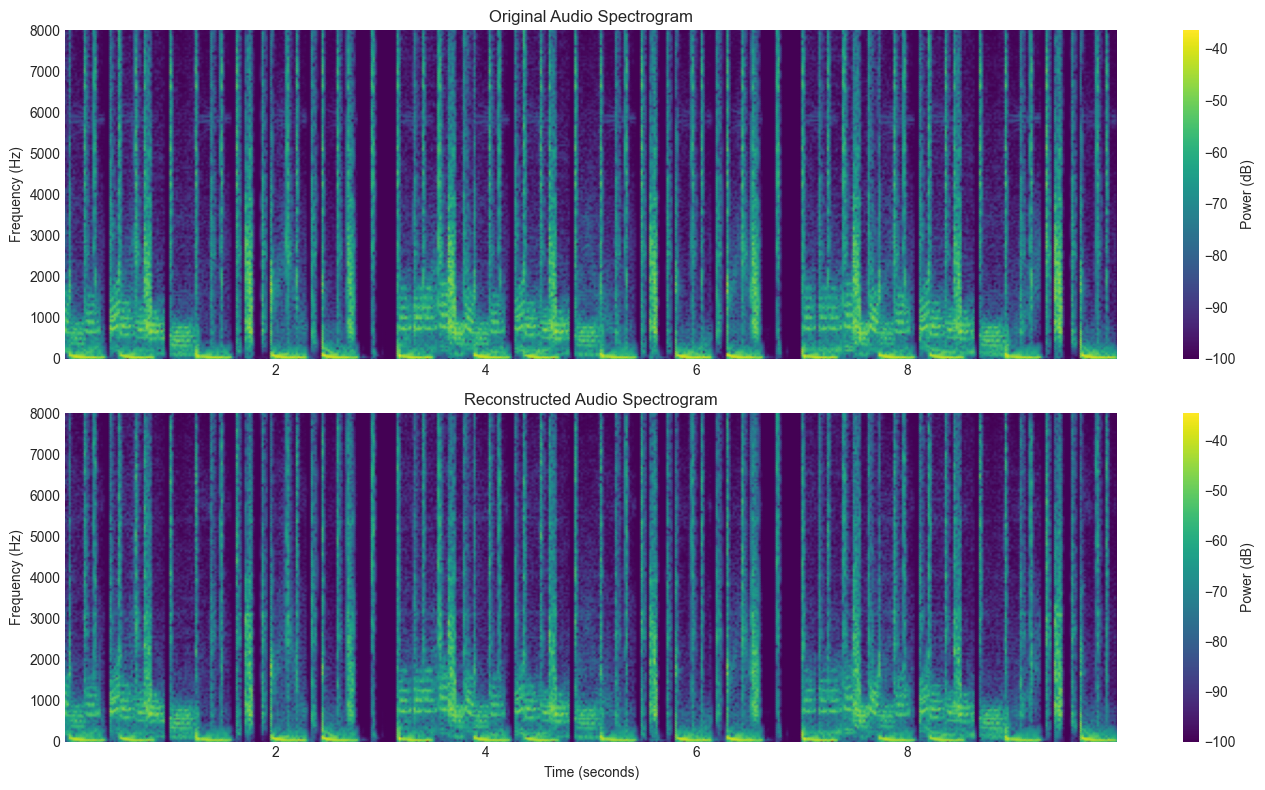

In [11]:
from scipy import signal as scipy_signal

# Ensure we have numpy arrays for spectral analysis
if torch.is_tensor(original_data):
    original_data = original_data.cpu().numpy()
if torch.is_tensor(reconstructed_data):
    reconstructed_data = reconstructed_data.cpu().numpy()

# Compute spectrograms
f_orig, t_orig, Sxx_orig = scipy_signal.spectrogram(original_data, fs=original_signal.sample_rate, nperseg=1024)
f_recon, t_recon, Sxx_recon = scipy_signal.spectrogram(reconstructed_data, fs=reconstructed_signal.sample_rate, nperseg=1024)

# Plot spectrograms
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Original spectrogram
im1 = axes[0].pcolormesh(t_orig, f_orig, 10 * np.log10(Sxx_orig + 1e-10), shading='gouraud', cmap='viridis')
axes[0].set_title('Original Audio Spectrogram')
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_ylim(0, 8000)  # Focus on lower frequencies
fig.colorbar(im1, ax=axes[0], label='Power (dB)')

# Reconstructed spectrogram
im2 = axes[1].pcolormesh(t_recon, f_recon, 10 * np.log10(Sxx_recon + 1e-10), shading='gouraud', cmap='viridis')
axes[1].set_title('Reconstructed Audio Spectrogram')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_ylim(0, 8000)  # Focus on lower frequencies
fig.colorbar(im2, ax=axes[1], label='Power (dB)')

plt.tight_layout()
plt.show()